### Screens and Filters

You can use any of the 100s of features as filtering and selection criteria for identifying novel investment opportunities. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sovai as sov

sov.token_auth(token="your_token_here")

In [3]:
df_business_risk = sov.data("factors/comprehensive")[["business_risk"]]; df_business_risk

business_risk
ticker date                     
A      1999-11-26         29.000
       1999-12-03         29.000
       1999-12-10         29.000
       1999-12-17         29.000
       1999-12-24         29.000
...                          ...
ZZ     2013-02-15         39.000
       2013-02-22         31.000
       2013-03-01         30.000
       2013-03-08         29.000
       2013-03-15         30.000

[9054165 rows x 1 columns]

In [18]:
df_business_risk = df_business_risk.add_price(); df_business_risk

business_risk  price
ticker date                            
A      1999-11-26         29.000 25.198
       1999-12-03         29.000 27.223
       1999-12-10         29.000 27.376
       1999-12-17         29.000 28.104
       1999-12-24         29.000 28.104
...                          ...    ...
ZZ     2013-02-15         39.000  2.190
       2013-02-22         31.000  2.180
       2013-03-01         30.000  2.190
       2013-03-08         29.000  2.200
       2013-03-15         30.000  2.190

[9054165 rows x 2 columns]

In [ ]:
# ["closeadj"]]; df_closeadj

In [ ]:
##. A nice multiple factor loading example

In [141]:
service_account_info = {}

Main Strategy:
Cumulative Returns Range: 0.91 - 76.16
Sharpe Ratio Range: -1.47 - 3.53


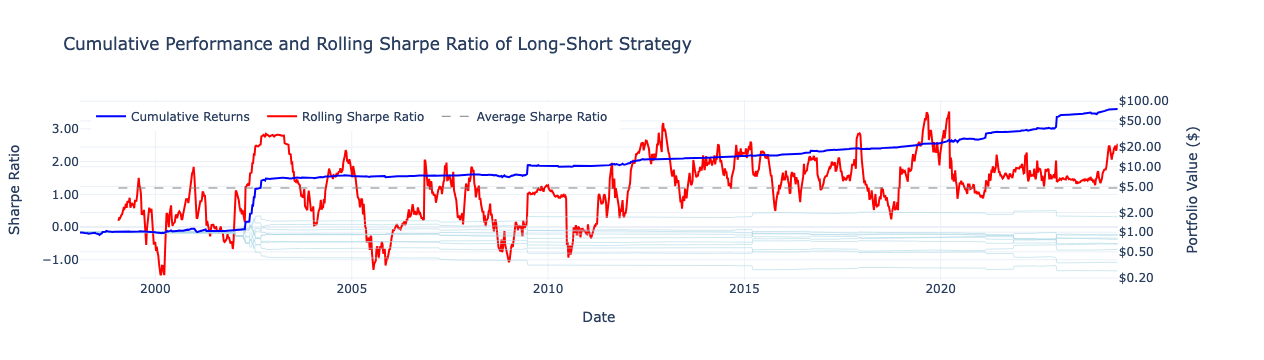

In [137]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def get_rebalance_dates(df):
    all_dates = df.index.get_level_values('date').unique()
    return all_dates[::4]  # Every 4th Friday

def long_short_strategy(df, rebalance_dates, random_allocation=False):
    returns = []
    random_returns = []
    
    for i in range(len(rebalance_dates) - 1):
        current_date = rebalance_dates[i]
        next_date = rebalance_dates[i + 1]
        
        current_data = df.xs(current_date, level='date', drop_level=False)
        all_stocks = current_data.index.get_level_values('ticker').unique().to_numpy()
        
        # Business risk-based allocation
        percentiles = current_data['business_risk']
        short_stocks = percentiles[percentiles <= 20].index.get_level_values('ticker').unique()
        long_stocks = percentiles[percentiles >= 80].index.get_level_values('ticker').unique()
        
        next_period_data = df.loc[(slice(None), slice(current_date, next_date)), :]
        next_period_returns = next_period_data['price'].groupby(level='ticker').pct_change()
        
        available_stocks = next_period_returns.index.get_level_values('ticker').unique()
        long_stocks = [stock for stock in long_stocks if stock in available_stocks]
        short_stocks = [stock for stock in short_stocks if stock in available_stocks]
        
        if long_stocks:
            long_returns = next_period_returns.loc[long_stocks].groupby(level='date').mean()
        else:
            long_returns = pd.Series(0, index=next_period_returns.index.get_level_values('date').unique())
        
        if short_stocks:
            short_returns = -next_period_returns.loc[short_stocks].groupby(level='date').mean()
        else:
            short_returns = pd.Series(0, index=next_period_returns.index.get_level_values('date').unique())
        
        strategy_returns = (long_returns + short_returns) / 2
        strategy_returns = strategy_returns.groupby(level='date').first().dropna()
        returns.append(strategy_returns)
        
        # Generate random allocations if specified
        if isinstance(random_allocation, int) and random_allocation > 0:
            period_random_returns = []
            for _ in range(random_allocation):
                np.random.shuffle(all_stocks)
                mid = len(all_stocks) // 2
                random_long, random_short = all_stocks[:mid], all_stocks[mid:]
                
                random_long = [stock for stock in random_long if stock in available_stocks]
                random_short = [stock for stock in random_short if stock in available_stocks]
                
                if random_long:
                    random_long_returns = next_period_returns.loc[random_long].groupby(level='date').mean()
                else:
                    random_long_returns = pd.Series(0, index=next_period_returns.index.get_level_values('date').unique())
                
                if random_short:
                    random_short_returns = -next_period_returns.loc[random_short].groupby(level='date').mean()
                else:
                    random_short_returns = pd.Series(0, index=next_period_returns.index.get_level_values('date').unique())
                
                random_strategy_returns = (random_long_returns + random_short_returns) / 2
                random_strategy_returns = random_strategy_returns.groupby(level='date').first().dropna()
                period_random_returns.append(random_strategy_returns)
            
            random_returns.append(period_random_returns)
    
    strategy_returns = pd.concat(returns).sort_index()
    
    if isinstance(random_allocation, int) and random_allocation > 0:
        random_returns = [pd.concat(rs).sort_index() for rs in zip(*random_returns)]
        return strategy_returns, random_returns
    else:
        return strategy_returns

def calculate_cumulative_returns(returns):
    return (1 + returns).cumprod()

def calculate_rolling_sharpe_ratio(returns, window=52, risk_free_rate=0):
    returns = returns.dropna()
    excess_returns = returns - risk_free_rate
    rolling_mean = excess_returns.rolling(window=window).mean()
    rolling_std = excess_returns.rolling(window=window).std()
    rolling_std = rolling_std.replace(0, np.nan)
    sharpe = (rolling_mean / rolling_std) * np.sqrt(52)
    return sharpe.replace([np.inf, -np.inf], np.nan).dropna()

def plot_cumulative_performance_with_sharpe(cumulative_returns, sharpe_ratio, random_cumulative_returns=None):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    average_sharpe = sharpe_ratio.mean()

    # Plot random allocation series if provided
    if random_cumulative_returns is not None:
        for rs in random_cumulative_returns:
            fig.add_trace(
                go.Scatter(
                    x=rs.index, 
                    y=rs.values,
                    mode='lines',
                    name='Random Allocation',
                    line=dict(color='lightblue', width=1),
                    opacity=0.6,
                    showlegend=False
                ),
                secondary_y=True
            )

    fig.add_trace(
        go.Scatter(
            x=cumulative_returns.index, 
            y=cumulative_returns.values,
            mode='lines',
            name='Cumulative Returns',
            line=dict(color='blue'),
            hovertemplate='Date: %{x}<br>Cumulative Returns: $%{y:.2f}<extra></extra>'
        ),
        secondary_y=True
    )

    fig.add_trace(
        go.Scatter(
            x=sharpe_ratio.index,
            y=sharpe_ratio.values,
            mode='lines',
            name='Rolling Sharpe Ratio',
            line=dict(color='red'),
            hovertemplate='Date: %{x}<br>Rolling Sharpe Ratio: %{y:.2f}<extra></extra>'
        ),
        secondary_y=False
    )
    
    fig.add_trace(
        go.Scatter(
            x=sharpe_ratio.index,
            y=[average_sharpe] * len(sharpe_ratio),
            mode='lines',
            name='Average Sharpe Ratio',
            line=dict(color='grey', dash='dash', width=1),
            hovertemplate='Date: %{x}<br>Average Sharpe Ratio: %{y:.2f}<extra></extra>'
        ),
        secondary_y=False
    )
    
    fig.update_layout(
        title='Cumulative Performance and Rolling Sharpe Ratio of Long-Short Strategy',
        xaxis_title='Date',
        yaxis_title='Sharpe Ratio',
        yaxis2_title='Portfolio Value ($)',
        template='plotly_white',
        legend=dict(x=0.01, y=0.99, orientation='h'),
        hovermode="x unified"
    )
    
    fig.update_yaxes(tickformat=".2f", secondary_y=False, range=[sharpe_ratio.min()*1.1, sharpe_ratio.max()*1.1])
    fig.update_yaxes(tickformat="$,.2f", secondary_y=True, type='log')
    
    fig.show()

# Main execution
def main(df_business_risk, random_allocation=False):
    rebalance_dates = get_rebalance_dates(df_business_risk.sort_index())
    
    if isinstance(random_allocation, int) and random_allocation > 0:
        strategy_returns, random_returns = long_short_strategy(df_business_risk, rebalance_dates.sort_values(), random_allocation)
        random_cumulative_returns = [calculate_cumulative_returns(r) for r in random_returns]
    else:
        strategy_returns = long_short_strategy(df_business_risk, rebalance_dates.sort_values(), random_allocation=False)
        random_cumulative_returns = None

    cumulative_returns = calculate_cumulative_returns(strategy_returns)
    rolling_sharpe = calculate_rolling_sharpe_ratio(strategy_returns, window=52)

    print("Main Strategy:")
    print(f"Cumulative Returns Range: {cumulative_returns.min():.2f} - {cumulative_returns.max():.2f}")
    print(f"Sharpe Ratio Range: {rolling_sharpe.min():.2f} - {rolling_sharpe.max():.2f}")

    plot_cumulative_performance_with_sharpe(cumulative_returns, rolling_sharpe, random_cumulative_returns)

# Run the main function
main(df_business_risk, random_allocation=False)  # Change this number to adjust the number of random series

In [ ]:
import pyfolio as pf

pf.create_full_tear_sheet(strategies_frame["simple_rnn_model"], live_start_date='2015-1-1',factor_loadings=True, factor_returns=bench)

Main Strategy:
Cumulative Returns Range: 0.91 - 76.16
Sharpe Ratio Range: -1.47 - 3.53


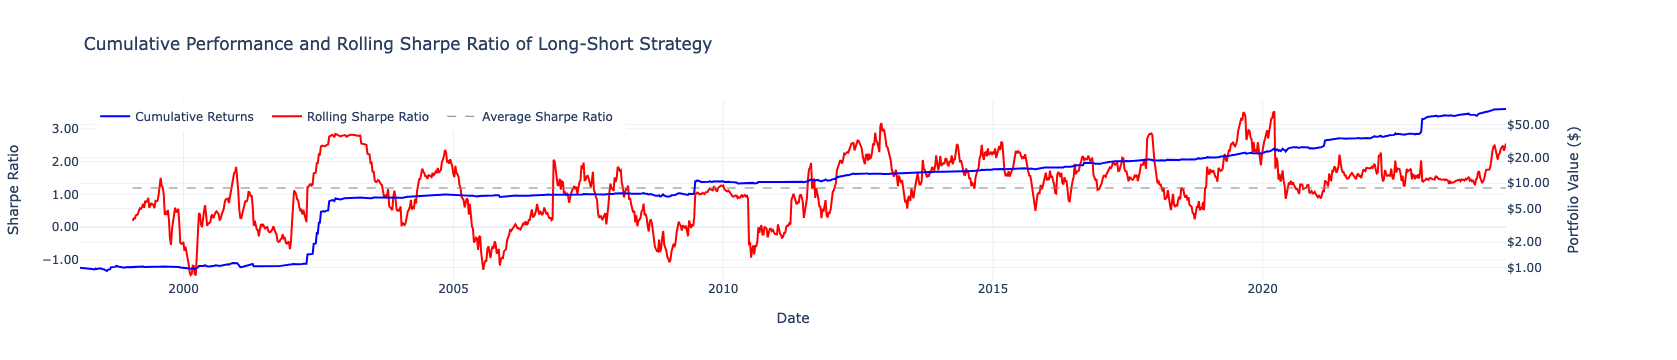

        date  symbol                                              price  \
0 1998-01-23  AAGIY1  date
1998-01-23   4.375
Name: price, dtype: fl...   
1 1998-01-23   ABACQ  date
1998-01-23   1.375
Name: price, dtype: fl...   
2 1998-01-23    ABCC  date
1998-01-23   0.969
Name: price, dtype: fl...   
3 1998-01-23   ABRX1  date
1998-01-23   23.000
Name: price, dtype: f...   
4 1998-01-23   ACCS2  date
1998-01-23   30.562
Name: price, dtype: f...   

                                              amount txn_dollars  sid  
0  date
1998-01-23   3.332
Name: price, dtype: fl...      14.577   24  
1  date
1998-01-23   10.602
Name: price, dtype: f...      14.577   61  
2  date
1998-01-23   15.044
Name: price, dtype: f...      14.577   72  
3  date
1998-01-23   0.634
Name: price, dtype: fl...      14.577  128  
4  date
1998-01-23   0.477
Name: price, dtype: fl...      14.577  183  


In [143]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def get_rebalance_dates(df):
    all_dates = df.index.get_level_values('date').unique()
    return all_dates[::4]  # Every 4th Friday

def long_short_strategy(df, rebalance_dates, initial_portfolio_value=10000, random_allocation=False):
    returns = []
    random_returns = []
    transactions = []
    portfolio_value = initial_portfolio_value
    previous_allocations = {}
    
    for i in range(len(rebalance_dates) - 1):
        current_date = rebalance_dates[i]
        next_date = rebalance_dates[i + 1]
        
        current_data = df.xs(current_date, level='date', drop_level=False)
        all_stocks = current_data.index.get_level_values('ticker').unique().to_numpy()
        
        # Business risk-based allocation
        percentiles = current_data['business_risk']
        short_stocks = percentiles[percentiles <= 20].index.get_level_values('ticker').unique()
        long_stocks = percentiles[percentiles >= 80].index.get_level_values('ticker').unique()
        
        next_period_data = df.loc[(slice(None), slice(current_date, next_date)), :]
        next_period_returns = next_period_data['price'].groupby(level='ticker').pct_change()
        
        available_stocks = next_period_returns.index.get_level_values('ticker').unique()
        long_stocks = [stock for stock in long_stocks if stock in available_stocks]
        short_stocks = [stock for stock in short_stocks if stock in available_stocks]
        
        # Calculate allocations and transactions
        all_selected_stocks = long_stocks + short_stocks
        allocations = {stock: 1/len(all_selected_stocks) if stock in long_stocks else -1/len(all_selected_stocks) for stock in all_selected_stocks}
        
        for stock in all_selected_stocks:
            current_price = current_data.loc[stock, 'price']
            allocation = allocations[stock]
            target_value = portfolio_value * abs(allocation)
            
            if stock in previous_allocations:
                previous_allocation = previous_allocations[stock]
                previous_shares = previous_allocation['shares']
                previous_value = previous_shares * current_price
                
                shares_change = (target_value - previous_value) / current_price
                transaction_value = shares_change * current_price
            else:
                shares_change = target_value / current_price
                transaction_value = target_value
            
            transactions.append({
                'date': current_date,
                'symbol': stock,
                'price': current_price,
                'amount': shares_change,
                'txn_dollars': transaction_value * (-1 if allocation < 0 else 1)
            })
            
            previous_allocations[stock] = {
                'shares': shares_change if stock not in previous_allocations else previous_allocations[stock]['shares'] + shares_change
            }
        
        # Calculate strategy returns
        if long_stocks:
            long_returns = next_period_returns.loc[long_stocks].groupby(level='date').mean()
        else:
            long_returns = pd.Series(0, index=next_period_returns.index.get_level_values('date').unique())
        
        if short_stocks:
            short_returns = -next_period_returns.loc[short_stocks].groupby(level='date').mean()
        else:
            short_returns = pd.Series(0, index=next_period_returns.index.get_level_values('date').unique())
        
        strategy_returns = (long_returns + short_returns) / 2
        strategy_returns = strategy_returns.groupby(level='date').first().dropna()
        returns.append(strategy_returns)
        
        # Update portfolio value
        portfolio_value *= (1 + strategy_returns.mean())
        
        # Generate random allocations if specified
        if isinstance(random_allocation, int) and random_allocation > 0:
            period_random_returns = []
            for _ in range(random_allocation):
                np.random.shuffle(all_stocks)
                mid = len(all_stocks) // 2
                random_long, random_short = all_stocks[:mid], all_stocks[mid:]
                
                random_long = [stock for stock in random_long if stock in available_stocks]
                random_short = [stock for stock in random_short if stock in available_stocks]
                
                if random_long:
                    random_long_returns = next_period_returns.loc[random_long].groupby(level='date').mean()
                else:
                    random_long_returns = pd.Series(0, index=next_period_returns.index.get_level_values('date').unique())
                
                if random_short:
                    random_short_returns = -next_period_returns.loc[random_short].groupby(level='date').mean()
                else:
                    random_short_returns = pd.Series(0, index=next_period_returns.index.get_level_values('date').unique())
                
                random_strategy_returns = (random_long_returns + random_short_returns) / 2
                random_strategy_returns = random_strategy_returns.groupby(level='date').first().dropna()
                period_random_returns.append(random_strategy_returns)
            
            random_returns.append(period_random_returns)
    
    strategy_returns = pd.concat(returns).sort_index()
    transactions_df = pd.DataFrame(transactions)
    transactions_df['sid'] = transactions_df['symbol'].astype('category').cat.codes
    
    if isinstance(random_allocation, int) and random_allocation > 0:
        random_returns = [pd.concat(rs).sort_index() for rs in zip(*random_returns)]
        return strategy_returns, random_returns, transactions_df
    else:
        return strategy_returns, transactions_df

def calculate_cumulative_returns(returns):
    return (1 + returns).cumprod()

def calculate_rolling_sharpe_ratio(returns, window=52, risk_free_rate=0):
    returns = returns.dropna()
    excess_returns = returns - risk_free_rate
    rolling_mean = excess_returns.rolling(window=window).mean()
    rolling_std = excess_returns.rolling(window=window).std()
    rolling_std = rolling_std.replace(0, np.nan)
    sharpe = (rolling_mean / rolling_std) * np.sqrt(52)
    return sharpe.replace([np.inf, -np.inf], np.nan).dropna()

def plot_cumulative_performance_with_sharpe(cumulative_returns, sharpe_ratio, random_cumulative_returns=None):
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    average_sharpe = sharpe_ratio.mean()

    # Plot random allocation series if provided
    if random_cumulative_returns is not None:
        for rs in random_cumulative_returns:
            fig.add_trace(
                go.Scatter(
                    x=rs.index, 
                    y=rs.values,
                    mode='lines',
                    name='Random Allocation',
                    line=dict(color='lightblue', width=1),
                    opacity=0.6,
                    showlegend=False
                ),
                secondary_y=True
            )

    fig.add_trace(
        go.Scatter(
            x=cumulative_returns.index, 
            y=cumulative_returns.values,
            mode='lines',
            name='Cumulative Returns',
            line=dict(color='blue'),
            hovertemplate='Date: %{x}<br>Cumulative Returns: $%{y:.2f}<extra></extra>'
        ),
        secondary_y=True
    )

    fig.add_trace(
        go.Scatter(
            x=sharpe_ratio.index,
            y=sharpe_ratio.values,
            mode='lines',
            name='Rolling Sharpe Ratio',
            line=dict(color='red'),
            hovertemplate='Date: %{x}<br>Rolling Sharpe Ratio: %{y:.2f}<extra></extra>'
        ),
        secondary_y=False
    )
    
    fig.add_trace(
        go.Scatter(
            x=sharpe_ratio.index,
            y=[average_sharpe] * len(sharpe_ratio),
            mode='lines',
            name='Average Sharpe Ratio',
            line=dict(color='grey', dash='dash', width=1),
            hovertemplate='Date: %{x}<br>Average Sharpe Ratio: %{y:.2f}<extra></extra>'
        ),
        secondary_y=False
    )
    
    fig.update_layout(
        title='Cumulative Performance and Rolling Sharpe Ratio of Long-Short Strategy',
        xaxis_title='Date',
        yaxis_title='Sharpe Ratio',
        yaxis2_title='Portfolio Value ($)',
        template='plotly_white',
        legend=dict(x=0.01, y=0.99, orientation='h'),
        hovermode="x unified"
    )
    
    fig.update_yaxes(tickformat=".2f", secondary_y=False, range=[sharpe_ratio.min()*1.1, sharpe_ratio.max()*1.1])
    fig.update_yaxes(tickformat="$,.2f", secondary_y=True, type='log')
    
    fig.show()

def main(df_business_risk, random_allocation=False):
    rebalance_dates = get_rebalance_dates(df_business_risk.sort_index())
    
    if isinstance(random_allocation, int) and random_allocation > 0:
        strategy_returns, random_returns, transactions_df = long_short_strategy(df_business_risk, rebalance_dates.sort_values(), random_allocation=random_allocation)
        random_cumulative_returns = [calculate_cumulative_returns(r) for r in random_returns]
    else:
        strategy_returns, transactions_df = long_short_strategy(df_business_risk, rebalance_dates.sort_values(), random_allocation=False)
        random_cumulative_returns = None

    cumulative_returns = calculate_cumulative_returns(strategy_returns)
    rolling_sharpe = calculate_rolling_sharpe_ratio(strategy_returns, window=52)

    print("Main Strategy:")
    print(f"Cumulative Returns Range: {cumulative_returns.min():.2f} - {cumulative_returns.max():.2f}")
    print(f"Sharpe Ratio Range: {rolling_sharpe.min():.2f} - {rolling_sharpe.max():.2f}")

    plot_cumulative_performance_with_sharpe(cumulative_returns, rolling_sharpe, random_cumulative_returns)
    
    return transactions_df

# Run the main function
transactions_df = main(df_business_risk, random_allocation=False)
print(transactions_df.head())

In [ ]:
df_price = sov.data("factors/comprehensive")

In [8]:
df_risk = df_comprehensive.get_latest("business_risk")[["business_risk"]]; df_risk

,,business_risk
ticker,date,
SCM,2024-07-12,100.000
DISTR,2024-07-12,100.000
VWEWW,2024-07-12,100.000
IVCBW,2024-07-12,100.000
CADL,2024-07-12,100.000
...,...,...
AXON,2024-07-12,1.000
ITUB,2024-07-12,1.000
WAT,2024-07-12,1.000


There are a lot of small firms in this list, I would like to isolate only large caps.

In [10]:
df_mega = df_risk.select_stocks("mega"); df_mega

,,business_risk
ticker,date,
SHEL,2024-07-12,92.000
AZN,2024-07-12,89.000
KO,2024-07-12,86.000
NVS,2024-07-12,86.000
UNH,2024-07-12,85.000
...,...,...
CRM,2024-07-12,8.000
IBM,2024-07-12,7.000
AMD,2024-07-12,4.000


From the large cap's I would prefer to select those with business risk sensitivity below 10 percent. 

In [12]:
df_ten = df_mega.query("business_risk <= 10")

In [13]:
df_ten

,,business_risk
ticker,date,
HD,2024-07-12,10.000
TMO,2024-07-12,9.000
ASML,2024-07-12,8.000
CRM,2024-07-12,8.000
IBM,2024-07-12,7.000
AMD,2024-07-12,4.000
INTC,2024-07-12,4.000
ACN,2024-07-12,2.000


And of course all of this could be written in one line! 

In [15]:
df_ten = sov.data("factors/comprehensive").get_latest("business_risk")[["business_risk"]].select_stocks("mega").query("business_risk <= 10"); df_ten

,,business_risk
ticker,date,
HD,2024-07-12,10.000
TMO,2024-07-12,9.000
ASML,2024-07-12,8.000
CRM,2024-07-12,8.000
IBM,2024-07-12,7.000
AMD,2024-07-12,4.000
INTC,2024-07-12,4.000
ACN,2024-07-12,2.000
